In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyper-parameters

learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomGrayscale(),
    # transforms.RandomPerspective(),
    transforms.ToTensor()]) #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

batch_size = 64

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [4]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)
model = ResNet34().to(device)

cuda


In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5, lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

curr_lr = learning_rate

In [6]:
loss_store_train =[]
loss_store_val = []
val_acc_store=[]
train_acc_store=[]
epoches=20
xaxis=np.arange(0.0,epoches)
for epoch in range(epoches): #I decided to train the model for 50 epochs
    train_loss = 0
    train_correct = 0
    train_samples = 0
    predictions = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        _, predictions = score.max(1)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
        train_correct += (predictions == targets).sum()
        train_samples += predictions.size(0)
    print(f"In epoch {epoch+1}: Training Loss {train_loss/len(train_dl):.3f} and Training Accuracy {float(train_correct) / float(train_samples) * 100:.2f}")
    loss_store_train.append(train_loss/len(train_dl))
    train_acc_store.append(float(train_correct) / float(train_samples) * 100)
    
    
    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    
    model.eval()
    valid_loss = 0
    num_correct = 0
    num_samples = 0
    predictions = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with Validation accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        val_acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

In epoch 1: Training Loss 1.573 and Training Accuracy 41.86
Got 5146 / 10000 with Validation accuracy 51.46
In epoch 2: Training Loss 1.080 and Training Accuracy 61.22
Got 6439 / 10000 with Validation accuracy 64.39
In epoch 3: Training Loss 0.839 and Training Accuracy 70.61
Got 7361 / 10000 with Validation accuracy 73.61
In epoch 4: Training Loss 0.684 and Training Accuracy 76.27
Got 7789 / 10000 with Validation accuracy 77.89
In epoch 5: Training Loss 0.583 and Training Accuracy 79.95
Got 7688 / 10000 with Validation accuracy 76.88
In epoch 6: Training Loss 0.514 and Training Accuracy 82.14
Got 8238 / 10000 with Validation accuracy 82.38
In epoch 7: Training Loss 0.465 and Training Accuracy 84.07
Got 8027 / 10000 with Validation accuracy 80.27
In epoch 8: Training Loss 0.418 and Training Accuracy 85.52
Got 8416 / 10000 with Validation accuracy 84.16
In epoch 9: Training Loss 0.386 and Training Accuracy 86.94
Got 8703 / 10000 with Validation accuracy 87.03
In epoch 10: Training Loss 0

Text(0, 0.5, 'Accuracy')

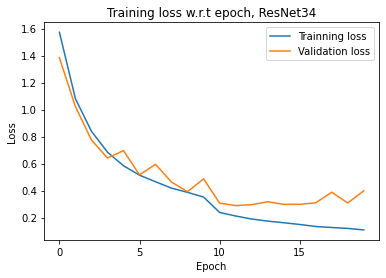

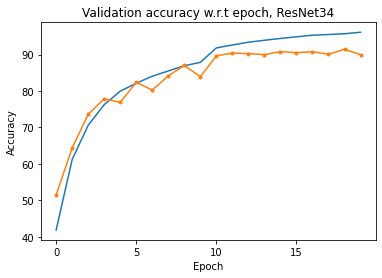

In [17]:
xi = list(range(epoches))
plt.xticks(range(0,epoches,5))
plt.figure(1)
plt.plot(xi,loss_store_train,label = 'Trainning loss')
plt.plot(xi,loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, ResNet34') 
plt.figure(2)
plt.xticks(range(0,epoches,5))
plt.plot(xi,train_acc_store, label = 'Training Accuracy')
plt.plot(xi,val_acc_store,marker='.', label = 'Validation Accuracy')
plt.title('Validation accuracy w.r.t epoch, ResNet34') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [ ]:
PATH = './resnet_try.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4, lr=0.01)


In [10]:
epoches=20
xaxis=np.arange(0.0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train1.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

KeyboardInterrupt: 